## Analyze whether PRCP varies more from year to year or from place to place.

In [50]:
import pandas as pd
import numpy as np
import urllib
import math
import matplotlib.pyplot as plt

In [2]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [3]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

In [21]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBSSSB'
meas='PRCP'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
2369
+------------------+------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|           coeff_1|           coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+------------------+------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
| 647.2023252437119|-819.1360790695871|-121.76002155743652|     67.1|SSSBSSSB| 37.8978|-122.5689|       PRCP|0.8613179540085606| 0.630363149839882|0.6242283267795034|0.8373202646192169|USC00046027

In [22]:
print df.columns

['coeff_1', 'coeff_2', 'coeff_3', 'elevation', 'label', 'latitude', 'longitude', 'measurement', 'res_1', 'res_2', 'res_3', 'res_mean', 'station', 'total_var', 'undefs', 'vector', 'year']


In [23]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
#Features=', '.join(['coeff_1', 'coeff_2', 'coeff_3', 'elevation', 'latitude', 'longitude',\
#          'res_1', 'res_2', 'res_3', 'res_mean', 'year'])
Features='station, year, coeff_1,coeff_2,coeff_3'
Query="SELECT %s FROM weather"%Features
print(Query)
pdf = sqlContext.sql(Query).toPandas()
pdf.head()

SELECT station, year, coeff_1,coeff_2,coeff_3 FROM weather


,station,year,coeff_1,coeff_2,coeff_3
0,USC00046027,1998.0,647.202325,-819.136079,-121.760022
1,USC00046027,1969.0,413.971869,-77.367954,663.834871
2,USW00093227,2010.0,418.802816,267.012867,386.239960
3,USC00047661,1958.0,188.684176,-782.375965,347.863623
4,USC00046336,1973.0,667.805468,-258.682004,-480.273835


### California Drought Analysis

In [111]:
rows2=df.rdd.map(lambda row:(row.station,row.year,unpackArray(row['vector'],np.int16))).sortBy(lambda x : x[1])

In [ ]:
rows=df.rdd.map(lambda row:(row.station,row.year,sum(unpackArray(row['vector'],np.float16))/np.count_nonzero(~np.isnan(unpackArray(row['vector'],np.float16)))))

In [60]:
rows.filter(lambda x : ~np.isnan(x[2])).countByKey()

defaultdict(int,
            {u'US1CAAL0008': 2,
             u'US1CACC0001': 2,
             u'US1CACC0018': 3,
             u'US1CASF0004': 2,
             u'US1CASJ0001': 1,
             u'US1CASJ0005': 1,
             u'US1CASM0001': 1,
             u'US1CASM0006': 4,
             u'US1CASM0014': 1,
             u'USC00040064': 8,
             u'USC00040227': 26,
             u'USC00040232': 22,
             u'USC00040693': 53,
             u'USC00041043': 6,
             u'USC00041206': 20,
             u'USC00041216': 2,
             u'USC00041281': 11,
             u'USC00041582': 2,
             u'USC00041583': 1,
             u'USC00041962': 13,
             u'USC00041967': 13,
             u'USC00042177': 34,
             u'USC00042580': 4,
             u'USC00043244': 4,
             u'USC00043650': 3,
             u'USC00043652': 6,
             u'USC00043735': 1,
             u'USC00043863': 1,
             u'USC00044500': 6,
             u'USC00044508': 1,
             u'

In [63]:
#'USW00023272' is the weather station with maximum number of data points.
data = rows.filter(lambda x : ~np.isnan(x[2])).filter(lambda x : x[0] == 'USW00023272').sortBy(lambda x : x[1]).collect()
(station,year,rain) = zip(*data)

In [113]:
y =  rows2.filter(lambda x : x[0] == 'USW00023272').map(lambda x:x[1]).collect()
d = rows2.filter(lambda x : x[0] == 'USW00023272').map(lambda x:x[2]).collect()
d = np.vstack(d)
d = d.transpose()
print d.shape

(365, 90)


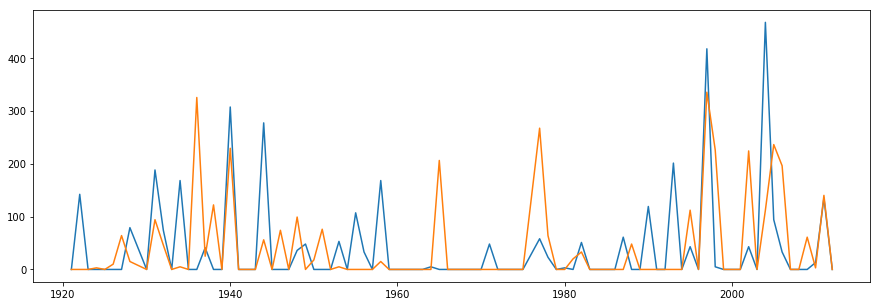

In [106]:
plt.plot(y, d[0])
plt.plot(y,d[1])
plt.show()

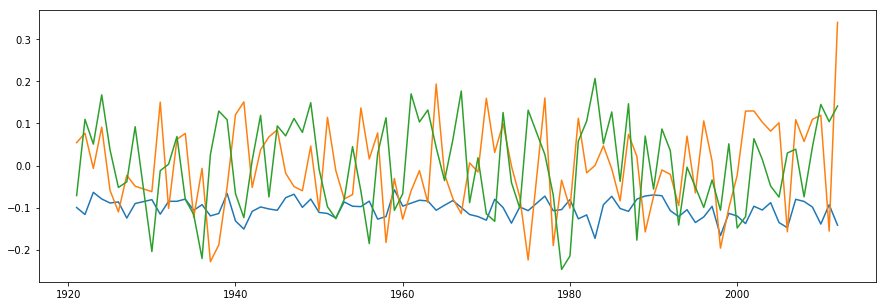

In [119]:
from numpy import linalg as LA
U, s, V = LA.svd(d)
plt.plot(y,V[0])
plt.plot(y,V[1])
plt.plot(y,V[2])
plt.show()

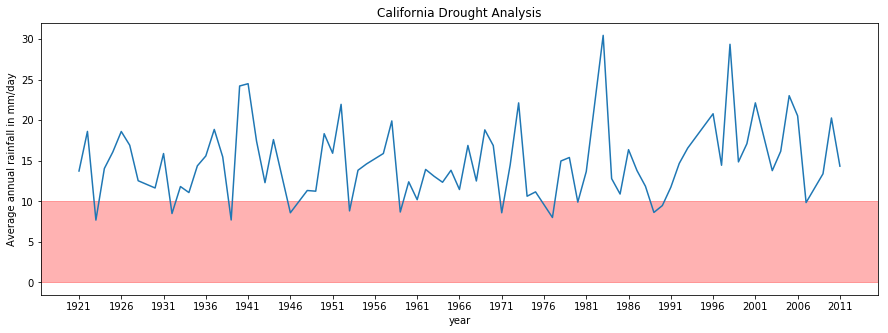

In [83]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

fig, ax = plt.subplots()
ax.plot(year,rain)
ax.xaxis.set_ticks(np.arange(min(year), max(year)+1, 5.0))
#ax.xticks(np.arange(min(year), max(year)+1, 5.0))
#plt.axhline(y=10, color='r', linestyle='-')
ax.axhspan(0, 10, alpha=0.3, color='red')
ax.set_xlabel('year')
ax.set_ylabel('Average annual rainfall in mm/day')
ax.set_title('California Drought Analysis')
plt.show()

In [31]:
year_station_table=pdf.pivot(index='year', columns='station', values='coeff_3')
year_station_table.head(10)

station,US1CAAL0001,US1CAAL0002,US1CAAL0003,US1CAAL0004,US1CAAL0007,US1CAAL0008,US1CAAL0011,US1CAAL0012,US1CACC0001,US1CACC0003,...,USW00023230,USW00023234,USW00023237,USW00023239,USW00023254,USW00023258,USW00023272,USW00023285,USW00093227,USW00093228
year,,,,,,,,,,,,,,,,,,,,,
1893.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1895.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1896.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1897.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1899.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1901.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1902.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1903.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Estimating the effect of the year vs the effect of the station

To estimate the effect of time vs. location on the first eigenvector coefficient we
compute:

* The average row: `mean-by-station`
* The average column: `mean-by-year`

We then compute the RMS before and after subtracting either  the row or the column vector.

In [32]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_year=np.nanmean(year_station_table,axis=1)
mean_by_station=np.nanmean(year_station_table,axis=0)
tbl_minus_year = (year_station_table.transpose()-mean_by_year).transpose()
tbl_minus_station = year_station_table-mean_by_station

print 'total RMS                   = ',RMS(year_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station),'Fraction explained=',(1-RMS(tbl_minus_station)/RMS(year_station_table))*100
print 'RMS removing mean-by-year   = ',RMS(tbl_minus_year),'Fraction explained=',(1-RMS(tbl_minus_year)/RMS(year_station_table))*100

total RMS                   =  171.693528795
RMS removing mean-by-station=  167.550306474 Fraction explained= 2.41314995933
RMS removing mean-by-year   =  70.5968252719 Fraction explained= 58.8820698325


In [20]:
T=year_station_table
print 'initial RMS=',RMS(T)
initial = RMS(T)
for i in range(5):
    mean_by_year=np.nanmean(T,axis=1)
    T=(T.transpose()-mean_by_year).transpose()
    print i,'after removing mean by year    =',RMS(T)
    mean_by_station=np.nanmean(T,axis=0)
    T=T-mean_by_station
    print i,'after removing mean by stations=',RMS(T)

initial RMS= 2663.65836018
0 after removing mean by year    = 631.978386814
0 after removing mean by stations= 417.030938104
1 after removing mean by year    = 402.178567872
1 after removing mean by stations= 399.370428592
2 after removing mean by year    = 398.594161623
2 after removing mean by stations= 398.337921582
3 after removing mean by year    = 398.242560165
3 after removing mean by stations= 398.203403306
4 after removing mean by year    = 398.18595506
4 after removing mean by stations= 398.17767193
